### Packages loading

In [1]:
import matplotlib.pyplot as plt
from qtm.evolution import environment, mutate, selection, crossover, utils
import qtm.constant
import qtm.ansatz
import qtm.qcompilation
import qtm.state
import qtm.evolution
import qiskit
import random
import numpy as np
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2


## 1. Quantum architecture search for quantum state preparation problem

This is state preparation circuit which is generated by classical method (amplitude encoding)

Step:   0%|          | 0/2 [31:10<?, ?it/s]


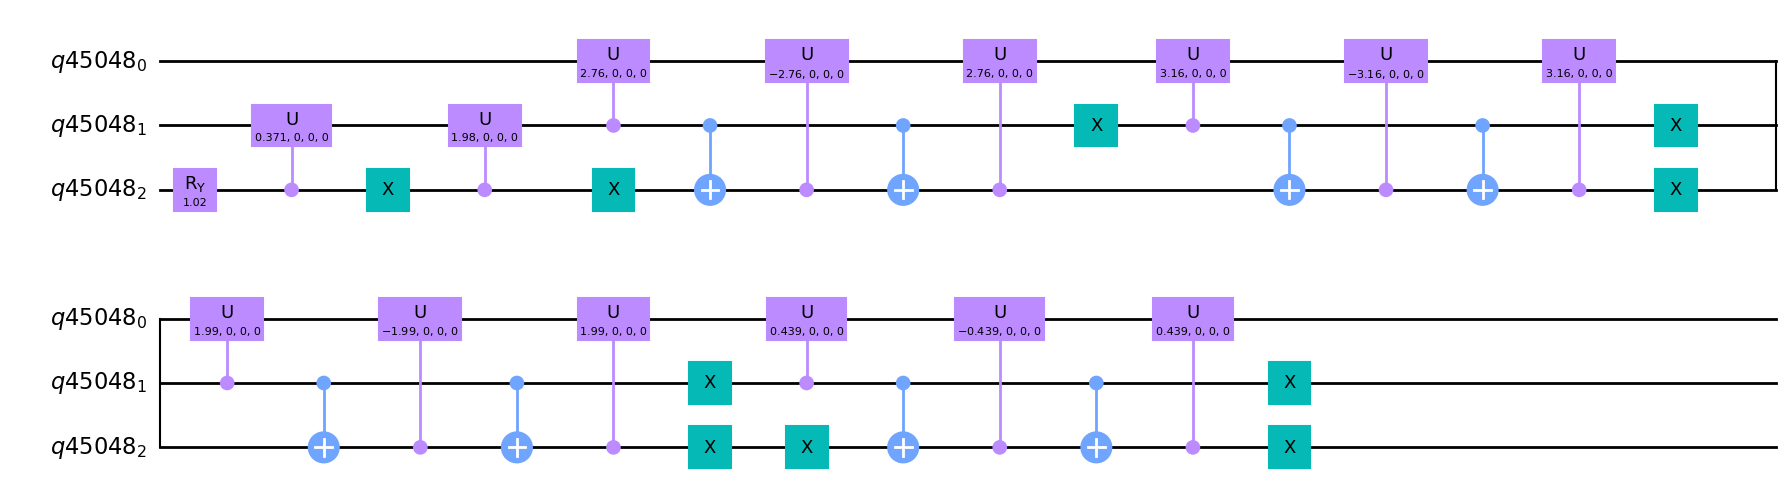

In [8]:
psi = 2*np.random.rand(2**3)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = encoder.qcircuit
qc.draw('mpl')


Now, we defind the problem which is need to solve

In [2]:
qc_haar = qtm.state.create_haar_state_inverse(3)


def compilation_fitness(qc: qiskit.QuantumCircuit, num_steps=5):
    compiler = qtm.qcompilation.QuantumCompilation(
        u=qc,
        vdagger=qc_haar,
        optimizer='adam',
        loss_func='loss_fubini_study'
    )
    compiler.fit(num_steps=num_steps, verbose=0)
    return np.average(compiler.loss_values)


def compilation_threshold(fitness_value):
    if fitness_value < 0.4:
        return True
    return False


Main algorithm, includes: init population, selection, crossover, mutate.

In [ ]:
params = {'depth': 5,
          'num_circuit': 16,  # Must mod 8 = 0
          'num_generation': 10,
          'num_qubits': 3,
          'threshold': compilation_threshold,
          'prob_mutate': 0.5}

env = environment.EEnvironment(
    params,
    fitness_func=compilation_fitness,
    selection_func=selection.elitist_selection,
    crossover_func=crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool=qtm.constant.operations
)

env.initialize_population()
env.evol()


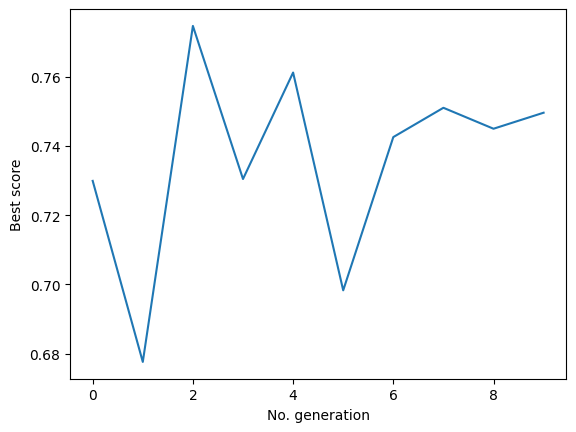

In [8]:
env.plot()

Test best candidate again

In [30]:
qc = env.best_candidate.qc
compiler = qtm.qcompilation.QuantumCompilation(
    u=qc,
    vdagger=qc_haar,
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler.fit(num_steps=100, verbose=1)


Step: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


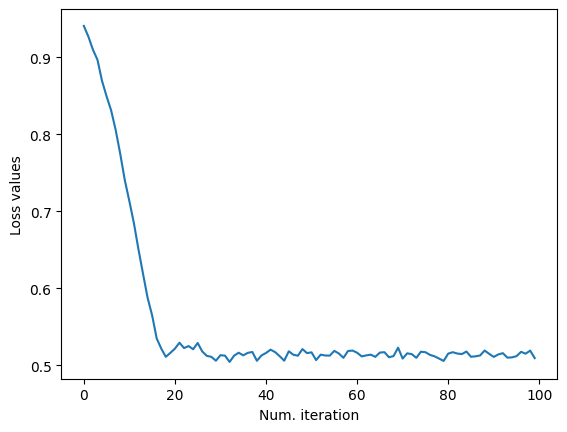

In [31]:
compiler.plot()


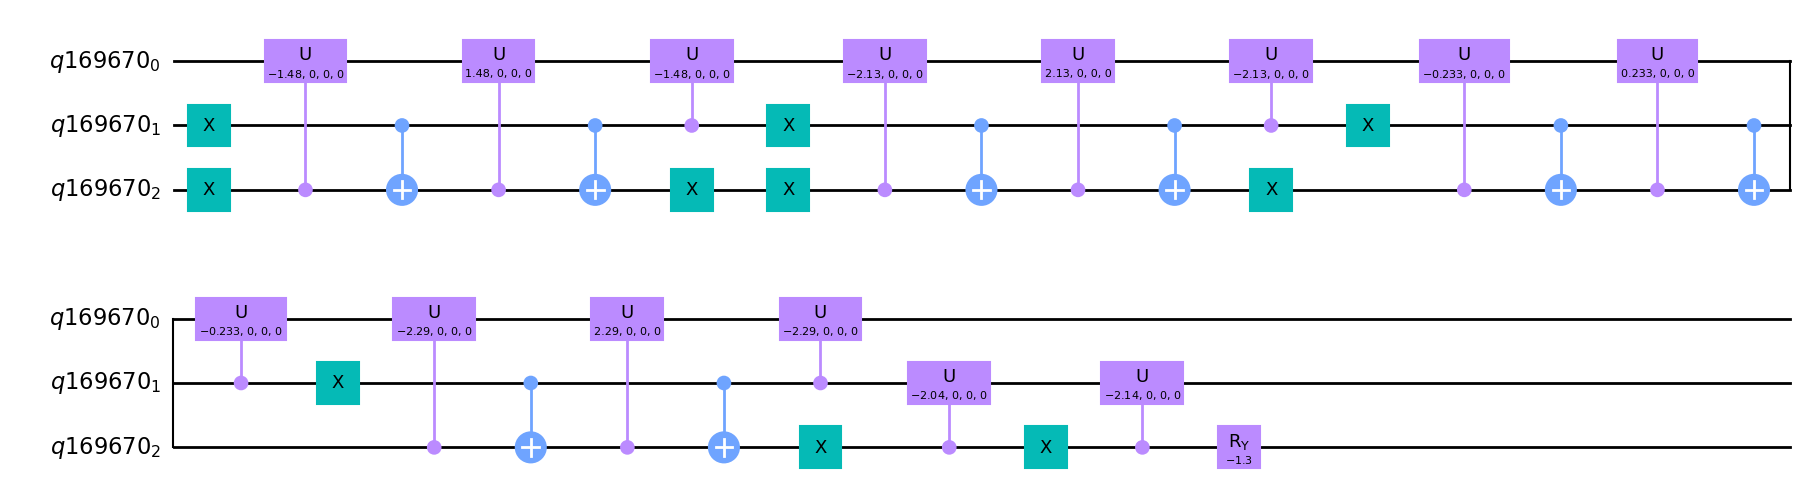

In [24]:
qc_haar.draw('mpl')


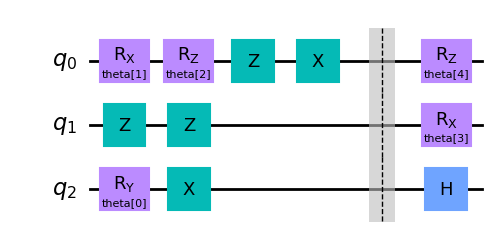

In [32]:
qc.draw('mpl')


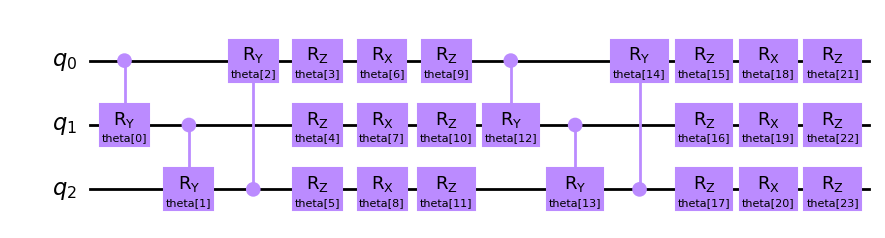

In [19]:
qtm.ansatz.Wchain_ZXZlayer_ansatz(3, 2).draw('mpl')


In [64]:
compiler2 = qtm.qcompilation.QuantumCompilation(
    # u = random_circuit.random_circuit(3, 10),
    # vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    u=qtm.ansatz.create_Wchain_layered_ansatz(3, 1),
    vdagger=qc_haar,
    optimizer='adam',
    loss_func='loss_fubini_study'
)
compiler2.fit(num_steps=100, verbose=1)


Step: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


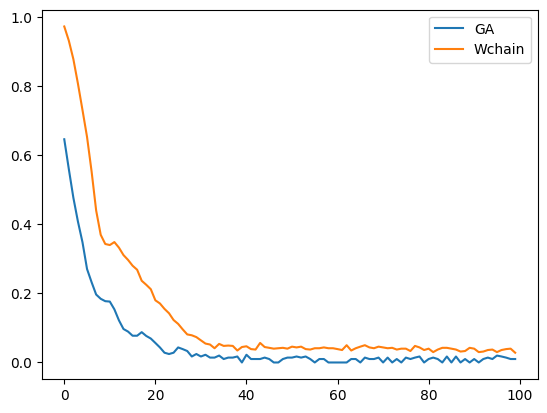

In [88]:
plt.plot(compiler.loss_values, label='GA')
plt.plot(compiler2.loss_values, label='Wchain')
plt.legend()
